In [76]:
import pandas as pd
import sys
import csv
from collections import defaultdict
import os

import matplotlib.pyplot as plt

In [ ]:
# load the txt file

smartwatch_txt = "/standard/UVA-DSA/NIST EMS Project Data/DataCollection_Spring_2025/CARS/03-29/stroke/t2/smartwatch/smartwatch_data_2025-03-29_16-24-11.txt"

# extract subject, session, and trial from the filename
date = smartwatch_txt.split('/')[-5]
scenario = smartwatch_txt.split('/')[-4]
trial = smartwatch_txt.split('/')[-3]

# output directory

output_dir = f"./{date}/{scenario}/{trial}/"
# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Mapping from MAC addresses to filenames
mac_to_name = {
    "28:3D:C2:EA:54:81": "smartwatch_01.csv",
    "04:29:2E:DE:DD:AF": "smartwatch_02.csv",
    "B0:4A:6A:49:5A:61": "smartwatch_03.csv"
}

# Dictionary to store lines grouped by MAC address
data_by_mac = defaultdict(list)

# Read and separate lines by MAC address
with open(smartwatch_txt, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) >= 7:
            mac = parts[1]
            data_by_mac[mac].append(parts)

# Save each MAC's data to a separate CSV file
for mac, rows in data_by_mac.items():
    filename = mac_to_name.get(mac, mac.replace(':', '_') + '.csv')
    filename = os.path.join(output_dir, filename)
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['timestamp', 'mac', 'index', 'imu_timestamp', 'x', 'y', 'z'])  # Header
        writer.writerows(rows)

print("Data has been successfully split into CSV files by MAC address.")


Data has been successfully split into CSV files by MAC address.


## Plots

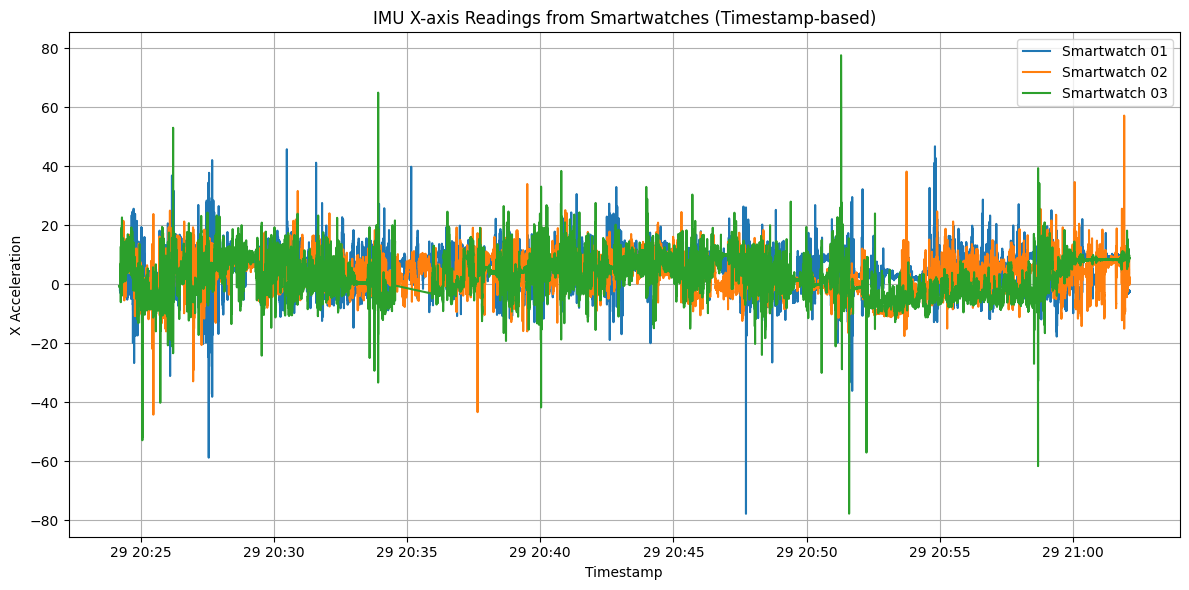

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# File names (should match what we saved earlier)
files = {
    'Smartwatch 01': f'{output_dir}/smartwatch_01.csv',
    'Smartwatch 02': f'{output_dir}/smartwatch_02.csv',
    'Smartwatch 03': f'{output_dir}/smartwatch_03.csv',
}

plt.figure(figsize=(12, 6))

for label, file in files.items():
    try:

        df = pd.read_csv(file)
        # Convert timestamp to milliseconds since it’s probably a big int (nanoseconds or ms)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # or use 'ms' if needed
        plt.plot(df['timestamp'], df['x'], label=label)
    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error processing {label}: {e}")

plt.title("IMU X-axis Readings from Smartwatches (Timestamp-based)")
plt.xlabel("Timestamp")
plt.ylabel("X Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Synchronization

In [79]:
# load each smartwatch csv file
smartwatch_01 = pd.read_csv(f'{output_dir}/smartwatch_01.csv')
smartwatch_02 = pd.read_csv(f'{output_dir}/smartwatch_02.csv')
smartwatch_03 = pd.read_csv(f'{output_dir}/smartwatch_03.csv')

# resample the data to 30Hz. drop mac column
smartwatch_01 = smartwatch_01.drop(columns=['mac'])
smartwatch_02 = smartwatch_02.drop(columns=['mac'])
smartwatch_03 = smartwatch_03.drop(columns=['mac'])

# convert timestamp to datetime
smartwatch_01['timestamp'] = pd.to_datetime(smartwatch_01['timestamp'], unit='ms')
smartwatch_02['timestamp'] = pd.to_datetime(smartwatch_02['timestamp'], unit='ms')
smartwatch_03['timestamp'] = pd.to_datetime(smartwatch_03['timestamp'], unit='ms')

# set timestamp as index
smartwatch_01.set_index('timestamp', inplace=True)
smartwatch_02.set_index('timestamp', inplace=True)
smartwatch_03.set_index('timestamp', inplace=True)

# resample to 30Hz
smartwatch_01 = smartwatch_01.resample('33.33ms').mean()
smartwatch_02 = smartwatch_02.resample('33.33ms').mean()
smartwatch_03 = smartwatch_03.resample('33.33ms').mean()

# fill missing values with the mean of the column
smartwatch_01.fillna(smartwatch_01.mean(), inplace=True)
smartwatch_02.fillna(smartwatch_02.mean(), inplace=True)
smartwatch_03.fillna(smartwatch_03.mean(), inplace=True)
# reset index
smartwatch_01.reset_index(inplace=True)
smartwatch_02.reset_index(inplace=True)
smartwatch_03.reset_index(inplace=True)

# drop the index column
smartwatch_01.drop(columns=['index'], inplace=True)
smartwatch_02.drop(columns=['index'], inplace=True)
smartwatch_03.drop(columns=['index'], inplace=True)

# convert timestamp back to milliseconds
smartwatch_01['timestamp'] = (smartwatch_01['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
smartwatch_02['timestamp'] = (smartwatch_02['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
smartwatch_03['timestamp'] = (smartwatch_03['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

# save the resampled data to csv
smartwatch_01.to_csv(f'{output_dir}/smartwatch_01_resampled.csv', index=False)
smartwatch_02.to_csv(f'{output_dir}/smartwatch_02_resampled.csv', index=False)
smartwatch_03.to_csv(f'{output_dir}/smartwatch_03_resampled.csv', index=False)

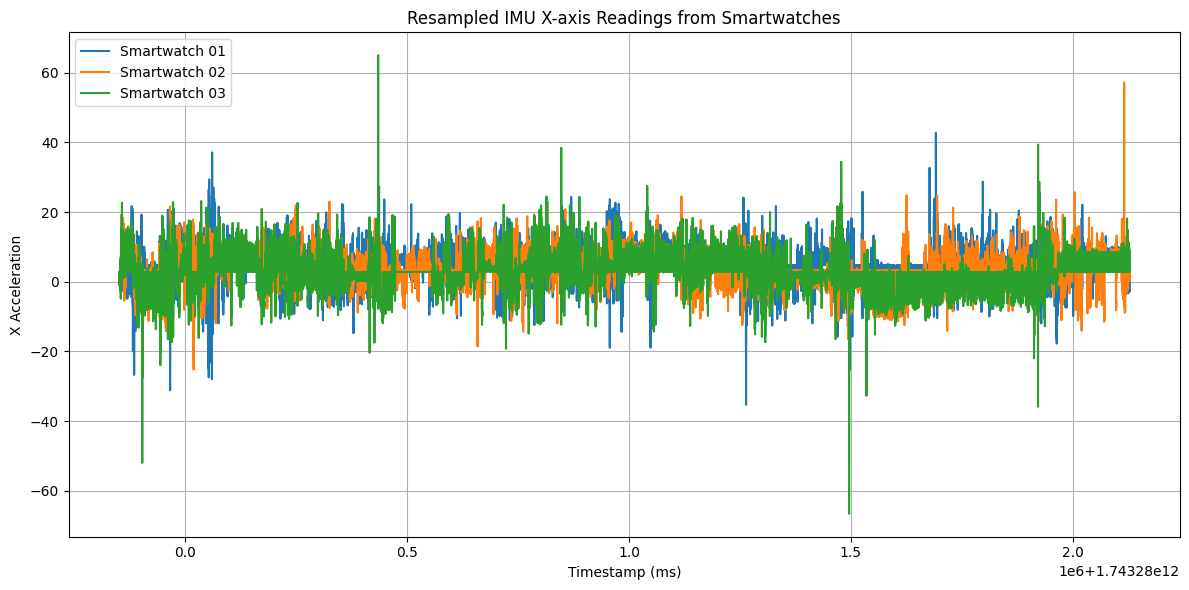

In [80]:
# plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(smartwatch_01['timestamp'], smartwatch_01['x'], label='Smartwatch 01')
plt.plot(smartwatch_02['timestamp'], smartwatch_02['x'], label='Smartwatch 02')
plt.plot(smartwatch_03['timestamp'], smartwatch_03['x'], label='Smartwatch 03')
plt.title("Resampled IMU X-axis Readings from Smartwatches")
plt.xlabel("Timestamp (ms)")
plt.ylabel("X Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# synchronize the 3 smartwatches

In [81]:
import pandas as pd

# Ensure data is sorted by timestamp
smartwatch_01 = smartwatch_01.sort_values('timestamp')
smartwatch_02 = smartwatch_02.sort_values('timestamp')
smartwatch_03 = smartwatch_03.sort_values('timestamp')

# Determine start times from each smartwatch
start_time_01 = smartwatch_01['timestamp'].iloc[0]
start_time_02 = smartwatch_02['timestamp'].iloc[0]
start_time_03 = smartwatch_03['timestamp'].iloc[0]

# Get the first timestamp in smartwatch_01 that is at or after the start of the other devices
first_timestamp_01_02 = smartwatch_01[smartwatch_01['timestamp'] >= start_time_02].iloc[0]['timestamp']
first_timestamp_01_03 = smartwatch_01[smartwatch_01['timestamp'] >= start_time_03].iloc[0]['timestamp']

# Filter smartwatch_02/3 so we only consider data from their own start times onward
smartwatch_02_filtered = smartwatch_02[smartwatch_02['timestamp'] >= first_timestamp_01_02]
smartwatch_03_filtered = smartwatch_03[smartwatch_03['timestamp'] >= first_timestamp_01_03]

# Merge smartwatch_01 with smartwatch_02 using merge_asof with backward direction.
sync_12 = pd.merge_asof(
    smartwatch_01, 
    smartwatch_02_filtered, 
    on='timestamp', 
    direction='backward',  # only allow matching if the reference time is at or after df2's time
    suffixes=('_01', '_02')
)

# Merge the result with smartwatch_03 in a similar manner.
synchronized_data = pd.merge_asof(
    sync_12, 
    smartwatch_03_filtered, 
    on='timestamp', 
    direction='backward', 
    suffixes=('', '_03')
)

# Rename columns for clarity (for smartwatch_03)
synchronized_data.rename(columns={'x': 'x_03', 'y': 'y_03', 'z': 'z_03'}, inplace=True)

# Fill missing data (i.e. cases with no valid match) with 0
synchronized_data.fillna(0, inplace=True)

# Save the synchronized data to CSV
synchronized_data.to_csv(f'{output_dir}/synchronized_data.csv', index=False)

# save separate csv files for each smartwatch 
synchronized_data[['timestamp', 'x_01', 'y_01', 'z_01']].to_csv(f'{output_dir}/synchronized_smartwatch_01.csv', index=False)
synchronized_data[['timestamp', 'x_02', 'y_02', 'z_02']].to_csv(f'{output_dir}/synchronized_smartwatch_02.csv', index=False)
synchronized_data[['timestamp', 'x_03', 'y_03', 'z_03']].to_csv(f'{output_dir}/synchronized_smartwatch_03.csv', index=False)




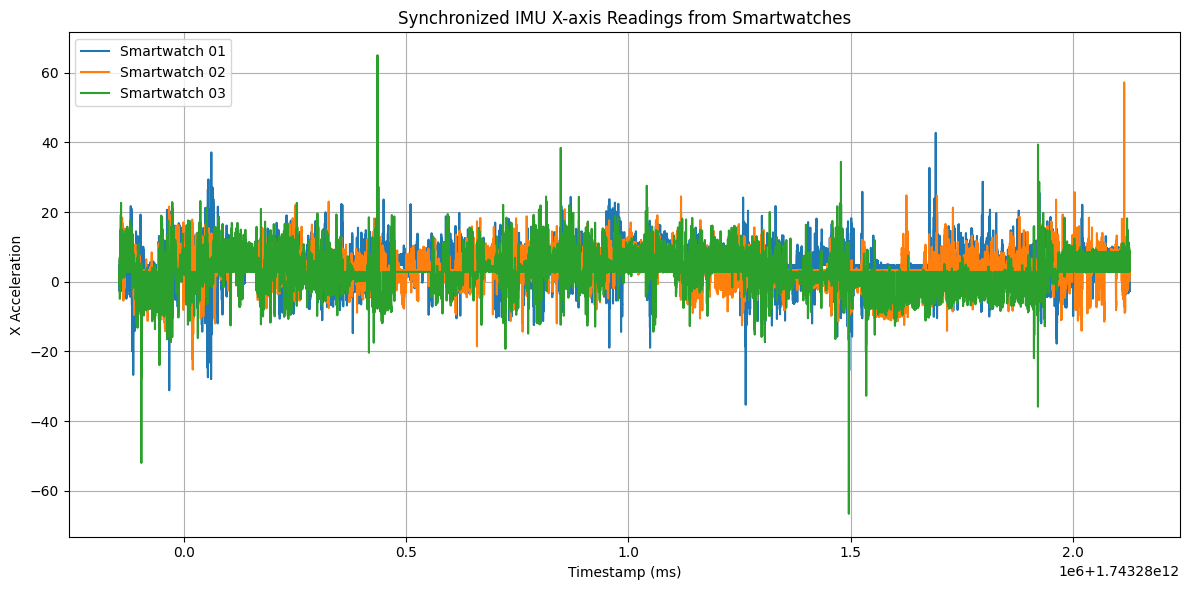

In [82]:
# Plot the synchronized data

plt.figure(figsize=(12, 6))
plt.plot(synchronized_data['timestamp'], synchronized_data['x_01'], label='Smartwatch 01')
plt.plot(synchronized_data['timestamp'], synchronized_data['x_02'], label='Smartwatch 02')
plt.plot(synchronized_data['timestamp'], synchronized_data['x_03'], label='Smartwatch 03')
plt.title("Synchronized IMU X-axis Readings from Smartwatches")
plt.xlabel("Timestamp (ms)")
plt.ylabel("X Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()